In [1]:
import sys
sys.path.append('../')
import torch
import dill
import os.path as op
import numpy as np
import hnn_core
from hnn_core import simulate_dipole, Network, read_params, JoblibBackend
import matplotlib as mpl
import matplotlib.pyplot as plt
import sbi.utils as utils
from sbi.inference.base import infer
import multiprocessing
import datetime
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from scipy import interpolate
import glob
import pandas as pd
import spike_train_functions
import numba


/home/ntolley/anaconda3/lib/python3.7/site-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)


In [2]:
data_path = '/home/ntolley/Jones_Lab/sbi_hnn/data/ERP/prerun_simulations/ERP_No_t10000_01162021_121408/'

prior_dict_file = open(data_path + 'prior_dict_ERP_No_t10000_01162021_121408.pkl', 'rb')
prior_dict = dill.load(prior_dict_file)
prior_dict_file.close()

prior_file = open(data_path + 'prior_ERP_No_t10000_01162021_121408.pkl', 'rb')
prior = dill.load(prior_file)
prior_file.close()

params_fname_file = open(data_path + 'params_fname_ERP_No_t10000_01162021_121408.pkl', 'rb')
params_fname = dill.load(params_fname_file)
params_fname.close()

dpl_files = sorted(glob.glob(data_path + 'data/dpl*'))
theta_files = sorted(glob.glob(data_path + 'data/theta*'))
spike_gids_files = sorted(glob.glob(data_path + 'data/spike_gids*'))
spike_times_files = sorted(glob.glob(data_path + 'data/spike_times*'))
spike_types_files = sorted(glob.glob(data_path + 'data/spike_types*'))

In [3]:
file_idx = 0
dpl = np.loadtxt(dpl_files[file_idx],delimiter=',')
theta = np.loadtxt(theta_files[file_idx],delimiter=',')
ERPYes_dpl = np.loadtxt('../../data/ERP/ERPYes_dpl.txt', delimiter=',')
ERPNo_dpl = np.loadtxt('../../data/ERP/ERPNo_dpl.txt', delimiter=',')

# with open(spike_gids_files[file_idx], 'rb') as f:
#     spike_gids = dill.load(f)
# unique_gids = np.unique([gid for l in spike_gids for gid in l[0]])
# num_sims = len(spike_gids)

# with open(spike_times_files[file_idx], 'rb') as f:
#     spike_times = dill.load(f)

# spike_times_list = []
# for gid in unique_gids:
#     unit_trains = []
#     for sim_idx in range(num_sims):
#         gid_mask = np.in1d(spike_gids[sim_idx][0], gid)
#         unit_trains.append(np.array(spike_times[sim_idx][0])[gid_mask])
#     spike_times_list.append(unit_trains)



In [4]:
inference = SNPE(prior=prior)
inference = inference.append_simulations(torch.as_tensor(theta).float(), torch.as_tensor(dpl).float())
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

/home/ntolley/anaconda3/lib/python3.7/site-packages/nflows/transforms/standard.py:76: DeprecationWarning: Use PointwiseAffineTransform
  warnings.warn("Use PointwiseAffineTransform", DeprecationWarning)
/home/ntolley/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
Neural network successfully converged after 53 epochs.


In [5]:
samples = posterior.sample((10,), x=ERPYes_dpl)

                        prior support. It may take a long time to collect the remaining
                        -12 samples. Consider interrupting (Ctrl-C)
                        and switching to `sample_with_mcmc=True`.



In [18]:
trial_sim_list = []
for gid, gid_times in enumerate(spike_times_list):
    trial_sim_list.append(vpTrialSimilarityMatrix(gid_times))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

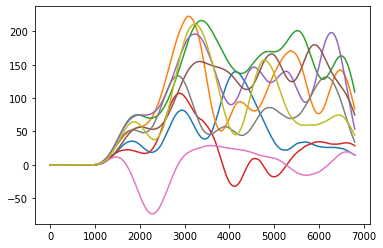

In [11]:
dpl_num = [0,32,63,554,24,6 , 555, 444, 333]
for idx in dpl_num:
    plt.plot(dpl[idx,:])